<a href="https://colab.research.google.com/github/danilodemoura/youtube_channel/blob/main/Class_07_Robin_Biot_Lumped_vs_Distributed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Class 7 — Convection (Robin BCs), Biot & Lumped vs Distributed Models
**Goals (≈15 min):**
1) Introduce Robin (convective) boundary conditions and derive ghost‑node formulas for FDM.  
2) Define Biot (Bi) and Fourier (Fo) numbers and the lumped‑capacitance criterion.  
3) Implement a 1D transient slab with convection on both faces (FDM).  
4) Compare the distributed FDM solution against the **lumped‑capacitance** model; analyze when lumped is valid.  
5) Exercise with different h, thickness, and materials; plus MATLAB and Simulink/Simscape notes (R2024a).



## 1. Robin (Convective) Boundary Conditions
For a boundary at temperature $T_s(t)$ exchanging heat with ambient $T_\infty$ by convection with coefficient $h$:
$$ -k\,\frac{\partial T}{\partial n}\Big|_s = h\,\big(T_s - T_\infty\big). $$
In 1D on $x\in[0,L]$ with outward normals at $x=0$ and $x=L$:
$$ -k\,\frac{\partial T}{\partial x}\Big|_{x=0} = h\,\big(T(0,t)-T_{\infty,0}\big), \qquad
 \phantom{-}k\,\frac{\partial T}{\partial x}\Big|_{x=L} = h\,\big(T(L,t)-T_{\infty,L}\big). $$
(Signs follow the outward normal.)

**Ghost‑node (second‑order) formulas** on a uniform grid $x_i=i\,\Delta x$:
At $x=0$ use $\partial T/\partial x \approx (T_1 - T_{-1})/(2\,\Delta x)$ to get
$$ T_{-1} = T_1 + 2\,\frac{\Delta x\,h}{k}\,\big(T_0 - T_{\infty,0}\big). $$
At $x=L$ use $\partial T/\partial x \approx (T_{N}-T_{N-2})/(2\,\Delta x)$ with $N\!=\!N_x-1$ to get
$$ T_{N} = T_{N-2} + 2\,\frac{\Delta x\,h}{k}\,\big(T_{N-1} - T_{\infty,L}\big). $$
Then discretize $T_{xx}$ at the boundary with the ghost node:  
$T_{xx}|_{0} \approx (T_1 - 2T_0 + T_{-1})/\Delta x^2$ and similarly at $x=L$.



## 2. Biot and Fourier Numbers; Lumped Capacitance
**Fourier number:** $\displaystyle \mathrm{Fo}=\frac{\alpha t}{L_c^2}$.  
**Biot number:** $\displaystyle \mathrm{Bi}=\frac{h L_c}{k}$, with a characteristic length $L_c$ (for a slab thickness $\delta$, a common choice is $L_c=\delta/2$).  

**Lumped‑capacitance model** assumes negligible internal gradients (uniform $T$ inside): valid when $\mathrm{Bi}\lesssim 0.1$.  
The energy balance for a body of volume $V$ and surface area $A$ gives
$$ \frac{dT}{dt} = -\frac{hA}{\rho c_p V}\big(T - T_\infty\big), \qquad
T(t) = T_\infty + \big(T_i - T_\infty\big)\exp\!\left(-\frac{hA}{\rho c_p V}t\right). $$



## 3. Problem: Copper Slab Cooled by Convection Both Sides
A slab of thickness $\delta=10\,\mathrm{mm}$ is initially at $T_i=100\,^\circ\mathrm{C}$ and is suddenly exposed at $t>0$ to air at $T_\infty=25\,^\circ\mathrm{C}$, with the same $h$ on **both** faces.  
Material: $k=400\,\mathrm{W/(m\,K)}$, $\rho=8900\,\mathrm{kg/m^3}$, $c_p=385\,\mathrm{J/(kg\,K)}$.  
Use 1D diffusion with convection (Robin) at $x=0$ and $x=L$ where $L=\delta$.

**Tasks:**
1) Compute $T(x,t)$ with explicit FDM (show profiles at several times).  
2) Compute the *spatial average* $\bar{T}(t)$ and compare against the **lumped** model.  
3) Investigate the effect of $h$ (e.g., 10, 100, 1000 W/m²K) in terms of Bi and the validity of lumped.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Material (Copper)
k = 400.0
rho = 8900.0
cp = 385.0
alpha = k/(rho*cp)

# Geometry and grid
L = 0.010   # slab thickness [m] (0..L)
Nx = 181
x = np.linspace(0, L, Nx)
dx = x[1]-x[0]

# Convection
h = 100.0          # W/m^2-K (you will vary this later)
T_inf_left = 25.0  # °C
T_inf_right = 25.0 # °C

# Initial condition
T_i = 100.0  # °C

# Stability for explicit 1D diffusion: r = alpha*dt/dx**2 <= 0.5
r_target = 0.4
dt = r_target*dx**2/alpha
print(f"alpha={alpha:.3e} m^2/s, dx={dx:.3e} m, dt={dt:.3e} s, r={alpha*dt/dx**2:.2f}")

# Times to plot
snap_times = [0.1, 0.5, 1.0, 2.0, 5.0]

# Helpers: lumped model for a unit area slab of thickness L (V=A*L => A/V=1/L)
A_to_V = 1.0/L
kappa = h * (2.0* A_to_V) / (rho*cp)  # both faces: total hA/V = 2h/L
# T_bar(t) = T_inf + (T_i - T_inf) * exp(-kappa * t)

alpha=1.167e-04 m^2/s, dx=5.556e-05 m, dt=1.058e-05 s, r=0.40


In [3]:
T = np.full(Nx, T_i)

snaps = {}
bar_T = []
Times = []
time = 0.0
Nt = int(np.ceil(max(snap_times)/dt))

for n in range(Nt+1):
    if np.isclose(time, snap_times, atol=dt).any():
        snaps[float(min(snap_times, key=lambda s: abs(s-time)))] = T.copy()
    bar_T.append(np.trapezoid(T, x)/L)
    Times.append(time)

    # march
    Tnew = T.copy()
    # interior
    Tnew[1:-1] = T[1:-1] + (alpha*dt/dx**2) * (T[2:] - 2*T[1:-1] + T[:-2])

    # Left boundary (x=0): ghost node formula
    Tghost_L = T[1] + 2*dx*(h/k)*(T[0]-T_inf_left)
    Tnew[0] = T[0] + (alpha*dt/dx**2) * (T[1] - 2*T[0] + Tghost_L)

    # Right boundary (x=L): outward normal +x, use ghost to the right
    Tghost_R = T[-2] + 2*dx*(h/k)*(T[-1]-T_inf_right)
    Tnew[-1] = T[-1] + (alpha*dt/dx**2) * (T[-2] - 2*T[-1] + Tghost_R)

    T = Tnew
    time += dt

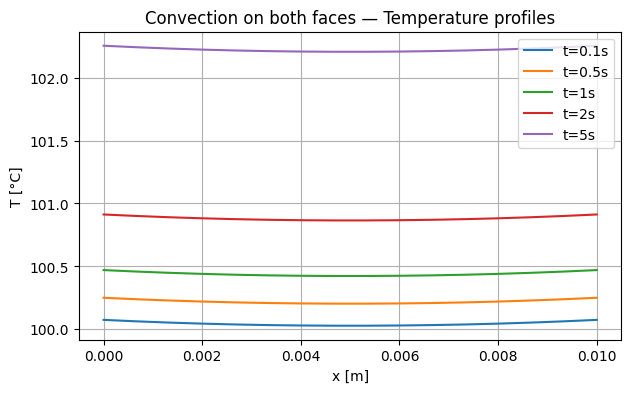

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


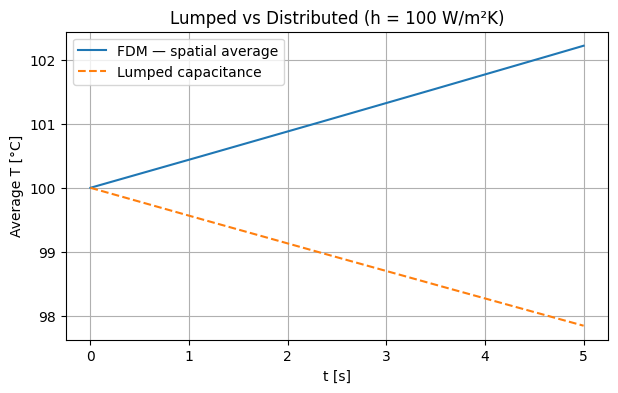

In [4]:

fig, ax = plt.subplots(figsize=(7,4))
for t in snap_times:
    ax.plot(x, snaps[t], label=f"t={t:g}s")
ax.set_xlabel('x [m]'); ax.set_ylabel('T [°C]'); ax.grid(True)
ax.set_title('Convection on both faces — Temperature profiles')
ax.legend(); plt.show()

# Lumped vs distributed (spatial average)
Times = np.array(Times)
bar_T = np.array(bar_T)
T_inf = 25.0
T_lumped = T_inf + (T_i - T_inf)*np.exp(-kappa*Times)

plt.figure(figsize=(7,4))
plt.plot(Times, bar_T, label='FDM — spatial average')
plt.plot(Times, T_lumped, '--', label='Lumped capacitance')
plt.xlabel('t [s]'); plt.ylabel('Average T [°C]'); plt.grid(True)
plt.title(f'Lumped vs Distributed (h = {h:g} W/m²K)')
plt.legend(); plt.show()


## 4. Discussion: When does lumped work?
For a slab, a common choice is $L_c=\delta/2$ so $\mathrm{Bi}=h(\delta/2)/k$.  
With $\delta=10\,\text{mm}$, $k=400$, and $h=100$, we get $\mathrm{Bi}\approx 100\times 0.005/400 = 0.00125$ (well within lumped validity).  
Increase $h$ or decrease $k$ to raise $\mathrm{Bi}$. As $\mathrm{Bi}$ grows beyond $\approx 0.1$, internal gradients matter and the lumped curve deviates from the FDM average.



## 5. Exercise — Sweep h and Thickness
**Problem.** Using the same copper properties and $T_i=100^\circ$C, $T_\infty=25^\circ$C:  
(a) Run the model for $h=10, 100, 1000\,\mathrm{W/m^2K}$ and $\delta=5, 10, 20\,\text{mm}$.  
(b) For each case, compute $\mathrm{Bi}$ and plot the average temperature vs time against the lumped prediction.  
(c) Determine the smallest time $t$ such that $\max_x|T(x,t)-\bar{T}(t)|<1^\circ$C (practical uniformity).

### Reference code cell (sweep)


/tmp/ipython-input-1345336991.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Tbar.append(np.trapz(T,x)/L)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


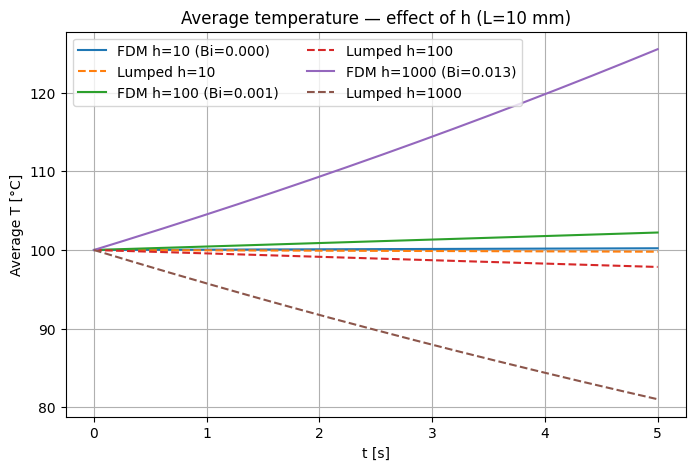

In [5]:

from math import ceil

def run_case(h, L):
    # grid resolution tied to L
    Nx = max(121, int(ceil(L/dx)))  # keep similar dx
    x = np.linspace(0, L, Nx)
    dx_loc = x[1]-x[0]
    dt_loc = 0.4*dx_loc**2/alpha
    T = np.full(Nx, T_i)
    tmax = 5.0
    Nt = int(np.ceil(tmax/dt_loc))
    Times, Tbar = [], []
    t=0.0
    for n in range(Nt+1):
        Times.append(t)
        Tbar.append(np.trapz(T,x)/L)
        # step
        Tnew = T.copy()
        Tnew[1:-1] = T[1:-1] + (alpha*dt_loc/dx_loc**2)*(T[2:] - 2*T[1:-1] + T[:-2])
        # ghost nodes
        Tghost_L = T[1] + 2*dx_loc*(h/k)*(T[0]-T_inf)
        Tnew[0] = T[0] + (alpha*dt_loc/dx_loc**2)*(T[1] - 2*T[0] + Tghost_L)
        Tghost_R = T[-2] + 2*dx_loc*(h/k)*(T[-1]-T_inf)
        Tnew[-1] = T[-1] + (alpha*dt_loc/dx_loc**2)*(T[-2] - 2*T[-1] + Tghost_R)
        T = Tnew
        t += dt_loc
    Times = np.array(Times); Tbar = np.array(Tbar)
    # lumped (two faces): A/V=2/L
    kappa = (2*h/L)/(rho*cp)
    T_lumped = T_inf + (T_i - T_inf)*np.exp(-kappa*Times)
    Bi = h*(L/2)/k
    return Times, Tbar, T_lumped, Bi

hs = [10, 100, 1000]
Ls = [0.005, 0.010, 0.020]
T_inf = 25.0

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
for h_ in hs:
    Times, Tbar, T_lump, Bi = run_case(h_, 0.010)
    plt.plot(Times, Tbar, label=f"FDM h={h_} (Bi={Bi:.3f})")
    plt.plot(Times, T_lump, '--', label=f"Lumped h={h_}")
plt.xlabel('t [s]'); plt.ylabel('Average T [°C]'); plt.grid(True)
plt.title('Average temperature — effect of h (L=10 mm)')
plt.legend(ncol=2)
plt.show()


## 6. MATLAB / Simulink / Simscape Notes (R2024a)
**MATLAB (explicit FDM skeleton):**
```matlab
k=400; rho=8900; cp=385; alpha=k/(rho*cp);
L=0.01; Nx=181; x=linspace(0,L,Nx)'; dx=x(2)-x(1);
h=100; Tinf=25; Ti=100;
r=0.4; dt=r*dx^2/alpha; Nt=ceil(5/dt);
T=Ti*ones(Nx,1);
for n=1:Nt
  Tnew=T;
  Tnew(2:end-1)=T(2:end-1)+alpha*dt/dx^2*(T(3:end)-2*T(2:end-1)+T(1:end-2));
  % Ghost nodes for convection both ends
  TghostL = T(2)+2*dx*(h/k)*(T(1)-Tinf);
  Tnew(1) = T(1) + alpha*dt/dx^2*( T(2)-2*T(1)+TghostL );
  TghostR = T(end-1)+2*dx*(h/k)*(T(end)-Tinf);
  Tnew(end) = T(end) + alpha*dt/dx^2*( T(end-1)-2*T(end)+TghostR );
  T=Tnew;
end
plot(x,T); grid on
```
**Simscape (Foundation > Thermal):**
1) Approximate the slab with a 1D ladder: cascade **Thermal Mass** blocks connected by **Thermal Conductive** blocks.  
2) Attach **Convective Heat Transfer** blocks at both end nodes to ambient ports at $T_\infty$. Set **Area** and **Film coefficient h**.  
3) Log temperatures along the chain to visualize internal gradients vs the lumped response (single **Thermal Mass** with total $C=\rho c_p V$ and two **Convective Heat Transfer** blocks in parallel to ambient).  
4) Solver: variable‑step **ode23t** or **ode15s**; ensure consistent units.



## 7. Takeaways
• Robin BCs model convection; ghost‑node formulas enforce them cleanly in FDM.  
• Lumped is excellent when $\mathrm{Bi}\lesssim 0.1$ but fails as internal gradients grow.  
• Comparing **average temperature** is a fair metric for lumped; profiles reveal why/when it deviates.
